# LSTM Composite Seq2Seq multi-day Price Sequence Prediction Demo
The goal of this demo is to show how a LSTM Composite Sequence-to-Sequence (LSTM Comp Seq2Seq) framework predicts a sequences of future prices. Specifically, our model is composed of an autoencoder and a predictor which the predictor utilizes the encoded deep representations from the autoencoder and learn to forecast multiple future timesteps of prices. Here, we forecast the 3 future timesteps of BTCUSD prices using an input of 48 timesteps. 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import utils

from LSTMComp import *
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Preparing and processing data:

In [4]:
btcusd = pd.read_csv('./data/btcusd.csv')
cols = {'Open':'eOpen', 'High':'eHigh','Low':'eLow','Close':'eClose'}
ethxbt = pd.read_csv('./data/iETHXBT.csv').rename(index=str, columns=cols)
bvol24H = pd.read_csv('./data/bvol24H.csv').rename(index=str, columns={'Close':'bvol24H'})
bvol7D = pd.read_csv('./data/bvol7D.csv').rename(index=str, columns={'Close':'bvol7D'})
evol7D = pd.read_csv('./data/evol7D.csv').rename(index=str, columns={'Close':'evol7D'})
cols = {'Open':'xOpen', 'High':'xHigh','Low':'xLow','Close':'xClose'}
xbtusd = pd.read_csv('./data/xbtusd.csv').rename(index=str, columns=cols)

btcusd = btcusd.set_index('Date')
ethxbt = ethxbt.set_index('Date')
ethxbt = ethxbt.drop(columns=['Volume'])
bvol24H = bvol24H.set_index('Date')
bvol7D = bvol7D.set_index('Date')
evol7D = evol7D.set_index('Date')
xbtusd = xbtusd.set_index('Date')
xbtusd = xbtusd.drop(columns=['Volume'])
# evol7D.index = pd.to_datetime(evol7D.index)
min_length = min(len(btcusd), len(ethxbt), len(bvol24H),len(bvol7D),len(evol7D),len(xbtusd))

btcusd = btcusd.iloc[-min_length:]
ethxbt = ethxbt.iloc[-min_length:]
bvol24H = bvol24H.iloc[-min_length:]
bvol7D = bvol7D.iloc[-min_length:]
evol7D = evol7D.iloc[-min_length:]
xbtusd = xbtusd.iloc[-min_length:]

data = pd.concat([btcusd, ethxbt, bvol24H, bvol7D, evol7D, xbtusd],axis=1).dropna()
feature_cols=data.columns
price_cols=['Close']
f = list(feature_cols)
f.remove('bvol24H')
f.remove('bvol7D')
f.remove('evol7D')
f.remove('Volume')
feature_cols = pd.Index(f)

#processing training and val dataset
val_size = 0.2
val_i = int(len(data) * (1 - val_size))

train = data.iloc[:val_i]
val = data.iloc[val_i:]

#normalize
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std

val_mean = val.mean()
val_std = val.std()
val = (val - val_mean) / val_std

After preparing and processing, we will train our model on the prices shown in blue and test our model on data shown in green:

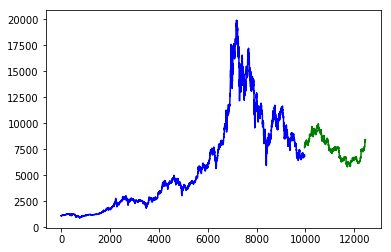

In [5]:
plt.figure()
plt.plot(btcusd.iloc[:val_i].Close.as_matrix(), color='blue')
plt.plot(range(len(btcusd.iloc[:val_i].Close.as_matrix()),len(btcusd)), btcusd.iloc[val_i:].Close.as_matrix(), color='green')
plt.show()

# Initializing LSTM Composite Seq2Seq

In [6]:
hidden_size = [128]

feature_size = len(feature_cols)
encoder_steps = 24
label_size = len(price_cols)
decoder_steps = 24

auto_lr = tf.placeholder(tf.float32)
pred_lr = tf.placeholder(tf.float32)

beta1 = 0.7
beta2 = 0.8
epsilon = 1e-6 #numerical stability
reverse = False

auto_optimizer = tf.train.AdamOptimizer(learning_rate=auto_lr, beta1=beta1, beta2=beta2, 
                                   epsilon=epsilon, name='auto_optimizer')
pred_optimizer = tf.train.AdamOptimizer(learning_rate=pred_lr, beta1=beta1, beta2=beta2, 
                                   epsilon=epsilon, name='pred_optimizer')
losses = []
ep = None
sess = tf.Session()
predictor = LSTMCompSeq2Seq(encoder_steps, feature_size, decoder_steps, label_size, 
                             hidden_size, sess, auto_optimizer, pred_optimizer, reverse=reverse)

INFO:tensorflow:Summary name encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0-grad is illegal; using encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel_0-grad instead.
INFO:tensorflow:Summary name encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0-grad is illegal; using encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias_0-grad instead.
INFO:tensorflow:Summary name autoencoder/decoder/d_weights:0-grad is illegal; using autoencoder/decoder/d_weights_0-grad instead.
INFO:tensorflow:Summary name autoencoder/decoder/d_biases:0-grad is illegal; using autoencoder/decoder/d_biases_0-grad instead.
INFO:tensorflow:Summary name autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0-grad is illegal; using autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/kernel_0-grad instead.
INFO:tensorflow:Summary name autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0-grad is illegal; using autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/bia

In [7]:
#load from checkpoint
saver = tf.train.Saver()
saver.restore(sess, './tmp/ckpts/btcusd-composite-128-24_24.ckpt')

INFO:tensorflow:Restoring parameters from ./tmp/ckpts/btcusd-composite-128-24_24.ckpt


We will first show our autoencoder's encoding quality on the test data:

In [11]:
start = 0
x, y = generate_test_sample(val[feature_cols].as_matrix().astype(np.float32), val[feature_cols].as_matrix().astype(np.float32), 
                            2000, start, encoder_steps, encoder_steps)
predictions = predictor.predict(x, predict_price=False)

In [12]:
col_index = 3
preds = remove_overlap(predictions[:,:,col_index].flatten(), encoder_steps)
x_ = remove_overlap(x[:,:,col_index].flatten(), encoder_steps)
feature_cols[col_index]

'Close'

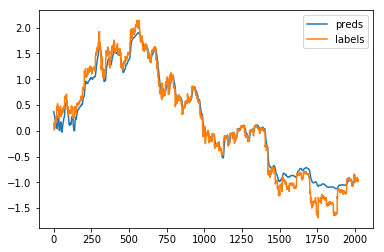

In [13]:
preds = pd.Series(preds,name='preds')
x_ = pd.Series(x_, name='labels')
pd.concat([preds.iloc[:], x_.iloc[:]],axis=1).plot()

Here's a close up on the autoencoding result of the BTCUSD closing price:

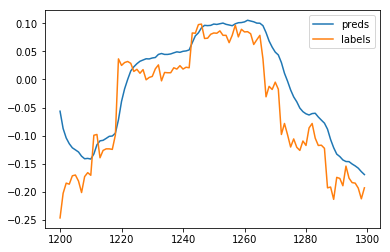

In [14]:
pd.concat([preds[1200:1300], x_[1200:1300]],axis=1).plot()

Here are the autoencoding result for ETHXBT closing price:

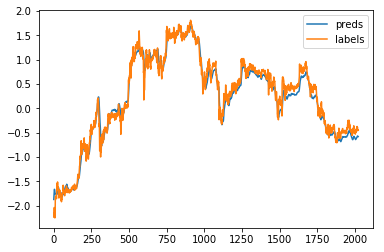

In [15]:
col_index = 7
preds = remove_overlap(predictions[:,:,col_index].flatten(), encoder_steps)
x_ = remove_overlap(x[:,:,col_index].flatten(), encoder_steps)
feature_cols[col_index]
preds = pd.Series(preds,name='preds')
x_ = pd.Series(x_, name='labels')
pd.concat([preds.iloc[:], x_.iloc[:]],axis=1).plot()

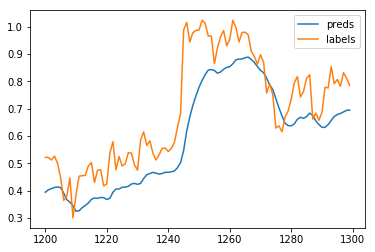

In [16]:
pd.concat([preds[1200:1300], x_[1200:1300]],axis=1).plot()

Finally, here are the prediction results for forecasting the next 24 timesteps based on a sequence of 24 timesteps:

In [17]:
start = 0
x, y = generate_test_sample(val[feature_cols].as_matrix().astype(np.float32), val[price_cols].as_matrix().astype(np.float32), 
                            2200, start, encoder_steps, decoder_steps)
y = remove_overlap(y.flatten(), decoder_steps)
predictions = predictor.predict(x)
predictions = remove_overlap(predictions.flatten(), decoder_steps)
predictions = pd.Series(predictions,name='preds')
y = pd.Series(y, name='labels')

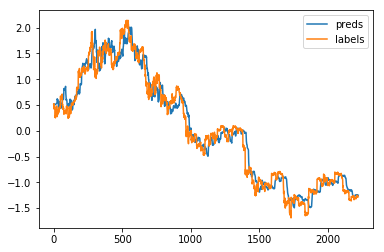

In [18]:
pd.concat([predictions[:], y[:]],axis=1).plot()

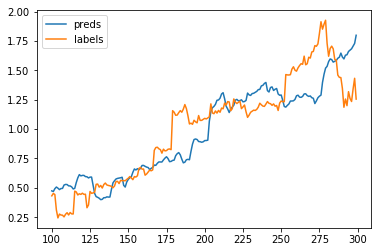

In [19]:
b = 100
c = 300
pd.concat([predictions[b:c], y[b:c]],axis=1).plot()

In [20]:
#output demo
import os
os.system('jupyter nbconvert --to html lstm-comp-demo.ipynb')

0